<a href="https://colab.research.google.com/github/AnaBelenCarbajal/Thesis/blob/main/Training_catLearningTask_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset novel shapes - Trainig**

1) Installing packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install osculari

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 7.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvi

In [3]:
#packages
import osculari
from osculari.paradigms.forced_choice import paradigm_utils
import torch.nn as nn

import os
import pandas as pd
import torch
import numpy as np
from matplotlib import pyplot as plt

from random import choice
import torchvision.transforms.functional as transform
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import v2
from torchvision.transforms import Pad
from torch.utils.data import DataLoader

from PIL import Image

In [4]:
# unzip folder (previously uploaded in collab)
!unzip '/content/drive/MyDrive/Thesis/Neural_network/Human category learning task/documents/CategoryLearningStimuli.zip' -d my_data

Archive:  /content/drive/MyDrive/Thesis/Neural_network/Human category learning task/documents/CategoryLearningStimuli.zip
   creating: my_data/CategoryLearningStimuli/
  inflating: my_data/__MACOSX/._CategoryLearningStimuli  
  inflating: my_data/CategoryLearningStimuli/348.png  
  inflating: my_data/__MACOSX/CategoryLearningStimuli/._348.png  
  inflating: my_data/CategoryLearningStimuli/360.png  
  inflating: my_data/__MACOSX/CategoryLearningStimuli/._360.png  
  inflating: my_data/CategoryLearningStimuli/176.png  
  inflating: my_data/__MACOSX/CategoryLearningStimuli/._176.png  
  inflating: my_data/CategoryLearningStimuli/88.png  
  inflating: my_data/__MACOSX/CategoryLearningStimuli/._88.png  
  inflating: my_data/CategoryLearningStimuli/162.png  
  inflating: my_data/__MACOSX/CategoryLearningStimuli/._162.png  
  inflating: my_data/CategoryLearningStimuli/189.png  
  inflating: my_data/__MACOSX/CategoryLearningStimuli/._189.png  
  inflating: my_data/CategoryLearningStimuli/77.pn

In [5]:
# root directory to data
root = "my_data/CategoryLearningStimuli/"
dic_pretraining = '/content/drive/MyDrive/Thesis/Neural_network/Pre-training on Animals shapes/'
dic_training = '/content/drive/MyDrive/Thesis/Neural_network/Human category learning task/documents/'

In [6]:
# get category labels
image_ID = os.listdir(root)

#remove ".DS_Store"
image_ID.remove(".DS_Store")
#image_ID.remove(".ipynb_checkpoints")

2) Defining parameters

In [7]:
# conditions
condition1 = {
    'A':[-30, 30],  #low var
    'D':[-80, 80]   #high var
    }

condition2 = {
    'A':[-80, 80], #high var
    'D':[-30, 30]  #low var
    }

In [8]:
# reference shapes angles --> categories
reference_shapeA = 0
reference_shapeB = 310
reference_shapeC = 260
reference_shapeD = 210

3) Get angles and directory

In [9]:
# get angles
angles = []
for image in image_ID:
  get_angle = image.replace('.png', '')
  transform_to_int = int(get_angle)
  angles.append(transform_to_int)

In [10]:
# get image directories
img_dir = []

for image in image_ID:
  folder_path = root + image
  img_dir.append(folder_path)

4) Create general dataset

In [11]:
data =  {'angle' : angles,
         'image' : image_ID,
         'img_dir' : img_dir}
# df
df_data = pd.DataFrame(data)
df_data = df_data.sort_values('angle')

5) Define functions to create dataset for cond1 and cond2 with corresponding labels of whether the shapes belong to the same condition as Reference shapes A, B, C and D

In [12]:
# functions to create datasets

# create datasets for reference shape A and D
def CreateLabelsAD (reference_shape, condition, dataset, stringCat):
  angles = dataset['angle'].tolist()
  labels = []

  for angle in angles:

    left_threshold = reference_shape + condition[stringCat][0]
    right_threshold = reference_shape + condition[stringCat][1]

    if stringCat == "A":
      left_threshold = left_threshold + 360
      if angle >= left_threshold or angle <= right_threshold:
        label_composition = "sameCat"
        label = label_composition
      else:
        label_composition = "diffCat"
        label = label_composition
    else:
      if angle >= left_threshold and angle <= right_threshold:
        label_composition = "sameCat"
        label = label_composition
      else:
        label_composition = "diffCat"
        label = label_composition

    labels.append(label)
  return labels

  # Create dictionary data
def CreateDictionary (dataframe):
  data_dicts = []

  for i in range(len(dataframe)):
    angle = dataframe.iloc[i, 0]
    image = dataframe.iloc[i, 1]
    img_dir = dataframe.iloc[i, 2]
    label_RefA = dataframe.iloc[i, 3]
    label_RefD = dataframe.iloc[i, 4]

    individual_dic =  {'angle' : angle,
                       'image' : image,
                       'img_dir' : img_dir,
                       'label_RefA' : label_RefA,
                       'label_RefD' : label_RefD}

    data_dicts.append(individual_dic)
  return data_dicts

6) Create datasets (4 for each condition)

In [13]:
# COND1 : getting labels for each reference shape

#refA
labels_RefA_Cond1 = CreateLabelsAD(reference_shapeA, condition1, df_data, "A")
#refD
labels_RefD_Cond1 = CreateLabelsAD(reference_shapeD, condition1, df_data, "D")

# add to dataframe
df_data_cond1 = df_data
df_data_cond1["label_RefA"] = labels_RefA_Cond1
df_data_cond1["label_RefD"] = labels_RefD_Cond1

data_Cond1 = CreateDictionary(df_data_cond1)
data_Cond1[0]

{'angle': 0,
 'image': '0.png',
 'img_dir': 'my_data/CategoryLearningStimuli/0.png',
 'label_RefA': 'sameCat',
 'label_RefD': 'diffCat'}

In [14]:
df_data_cond1

,angle,image,img_dir,label_RefA,label_RefD
310,0,0.png,my_data/CategoryLearningStimuli/0.png,sameCat,diffCat
217,1,1.png,my_data/CategoryLearningStimuli/1.png,sameCat,diffCat
194,2,2.png,my_data/CategoryLearningStimuli/2.png,sameCat,diffCat
0,3,3.png,my_data/CategoryLearningStimuli/3.png,sameCat,diffCat
237,4,4.png,my_data/CategoryLearningStimuli/4.png,sameCat,diffCat
...,...,...,...,...,...
7,356,356.png,my_data/CategoryLearningStimuli/356.png,sameCat,diffCat
165,357,357.png,my_data/CategoryLearningStimuli/357.png,sameCat,diffCat
8,358,358.png,my_data/CategoryLearningStimuli/358.png,sameCat,diffCat
220,359,359.png,my_data/CategoryLearningStimuli/359.png,sameCat,diffCat


In [ ]:
# COND2 : getting labels for each reference shape

#refA
labels_RefA_Cond2 = CreateLabelsAD(reference_shapeA, condition2, df_data, "A")
#refD
labels_RefD_Cond2 = CreateLabelsAD(reference_shapeD, condition2, df_data, "D")

# add to dataframe
df_data_cond2 = df_data
df_data_cond2["label_RefA"] = labels_RefA_Cond2
df_data_cond2["label_RefD"] = labels_RefD_Cond2

data_Cond2 = CreateDictionary(df_data_cond2)
data_Cond2[0]

{'angle': 1,
 'image': '1.png',
 'img_dir': 'my_data/CategoryLearningStimuli/1.png',
 'label_RefA': 'sameCat',
 'label_RefD': 'diffCat'}

7) Create and select random positions for images

In [15]:
# read positions.txt
#read
PATH = '/content/drive/MyDrive/Thesis/Neural_network/Human category learning task/documents/positions.txt'
positions = np.loadtxt(PATH)
positions = positions.tolist()
positions = [[int(float(j)) for j in i] for i in positions]
positions[:5]

[[23, 25, 21, 19],
 [26, 26, 18, 18],
 [31, 7, 13, 37],
 [27, 5, 17, 39],
 [31, 10, 13, 34]]

8) Define class for CNN

In [16]:
# function to gove 'random' color jitter
import torch
from torchvision import transforms
from torchvision.transforms import functional as F

def compute_parameters(brightness, contrast, saturation, hue): #tuples
  # pool size of static random values
  N_values = 1000

  # Create list of random values
  rng = np.random.default_rng(seed=42)
  brightness = list(rng.uniform(low=brightness[0], high=brightness[1], size=(N_values,)))
  contrast = list(rng.uniform(low=contrast[0], high=contrast[1], size=(N_values,)))
  saturation = list(rng.uniform(low=saturation[0], high=saturation[1], size=(N_values,)))
  hue = hue

  # Define specific jitter values
  brightness_factor = np.random.choice(brightness)  # Change this to your specific value
  contrast_factor = np.random.choice(contrast)    # Change this to your specific value
  saturation_factor = 0.8  # Change this to your specific value
  hue_factor = 0.1         # Change this to your specific value

  return brightness_factor, contrast_factor, saturation_factor, hue_factor


def apply_ColorJitter(tensor, brightness_factor, contrast_factor, saturation_factor, hue_factor):

  # Convert tensor to PIL Image
  pil_image = transforms.ToPILImage()(tensor)

  # Apply the transformations using functional API on PIL image
  jittered_image = F.adjust_brightness(pil_image, brightness_factor)
  jittered_image = F.adjust_contrast(jittered_image, contrast_factor)
  jittered_image = F.adjust_saturation(jittered_image, saturation_factor)
  jittered_image = F.adjust_hue(jittered_image, hue_factor)

  # Convert PIL Image back to tensor
  jittered_tensor = transforms.ToTensor()(jittered_image)

  return jittered_tensor

In [21]:
class ShapeImageDataset (Dataset):
  # return two images, with 50% chance in same or different category and ground truth

  # __init__
  def __init__(self, length, reference_shape, data_dict, positions, transform=None):
    self.length = length
    self.reference_shape = reference_shape
    self.data = data_dict
    self.transform = transform
    self.positions = positions
    self.left_right = [1, 0]
    self.same_category = [1, 0]

  # __len__
  def __len__(self):
    return self.length

  # function to pick image from 'diffCat'
  def select_Cat_image(self, label, category):
    result = []
    for item in self.data:
      if item[label] == category:
        result.append(item)
    return choice(result)

  # function to read images
  def read_image_from_directory(self, img_dir):
    return read_image(img_dir, ImageReadMode.RGB)

  # function to get labels corresponding to reference shape
  def get_label(self, reference_shape):
    if reference_shape == 0:
      label = 'label_RefA'
    else:
      label = 'label_RefD'
    return label

  # __getitem__
  def __getitem__(self, idx):

    # get label of reference shape (e.g. "label_RefA")
    label = self.get_label(self.reference_shape)

    # img1 should be reference shape
    ref_shape_image = self.data[self.reference_shape]
    ref_shape_label = ref_shape_image[label]
    ref_shape_dir = ref_shape_image['img_dir']

    # img2 should be test shape: from all angles
    if self.length <= 360:
      test_shape_angle_360 = idx
    elif self.length > 360 and self.length <= (360*2):
      if idx > 360:
        test_shape_angle_360 = idx - 360
      else:
        test_shape_angle_360 = idx
    elif self.length > (360*2) and self.length <= (360*3):
      if idx > 360 and idx <= (360*2):
        test_shape_angle_360 = idx - 360
      elif idx > (360*2) and idx <= (360*3):
        test_shape_angle_360 = idx - (360*2)
      else:
        test_shape_angle_360 = idx
    else:
      if idx > 360 and idx <= (360*2):
        test_shape_angle_360 = idx - 360
      elif idx > (360*2) and idx <= (360*3):
        test_shape_angle_360 = idx - (360*2)
      elif idx > (360*3) and idx <= (360*4):
        test_shape_angle_360 = idx - (360*3)
      else:
        test_shape_angle_360 = idx

    # get test shape
    test_shape_image = self.data[test_shape_angle_360]

    # 50-50 choose image 2 from same category
    same = choice(self.same_category)
    if same == 1:
      if test_shape_image[label] == ref_shape_label:
        pass
      else:
        test_shape_image = self.select_Cat_image(label, 'sameCat')
    else:
      if test_shape_image[label] != ref_shape_label:
        pass
      else:
        test_shape_image = self.select_Cat_image(label, 'diffCat')

    # get test shape label and directory
    test_shape_label = test_shape_image[label]
    test_shape_dir = test_shape_image['img_dir']

    # read images
    img1 = self.read_image_from_directory(ref_shape_dir)
    img2 = self.read_image_from_directory(test_shape_dir)

    # gt
    if ref_shape_label == test_shape_label:
      gt = 1
    else:
      gt = 0

    # apply transformations
    # resize to 180x180
    resize = v2.Resize([180,180])
    img1 = resize(img1)
    img2 = resize(img2)
    # apply padding
    img1_selected_position = choice(self.positions)
    img2_selected_position = choice(self.positions)
    padding_img1 = Pad(padding = img1_selected_position, fill=128)
    padding_img2 = Pad(padding = img2_selected_position, fill=128)
    img1 = padding_img1(img1)
    img2 = padding_img2(img2)

    #apply ColorJitter
    [brightness_factor, contrast_factor, saturation_factor, hue_factor] = compute_parameters(
        brightness=(0.5,0.8), contrast=(0.1,1), saturation=(-0.5,0.5), hue=0)
    img1 = apply_ColorJitter(img1, brightness_factor, contrast_factor, saturation_factor, hue_factor)
    img2 = apply_ColorJitter(img2, brightness_factor, contrast_factor, saturation_factor, hue_factor)

    # apply more transformations
    if self.transform:
      img1 = self.transform(img1)
      img2 = self.transform(img2)

    # left and right positions change randomly
    # return tensors for image 1 and image 2 and a ground truth
    if choice(self.left_right) == 1:
      img_left = img1
      img_right = img2
    else:
      img_left = img2
      img_right = img1

    #return to_grayscale_rgb(img_left), to_grayscale_rgb(img_right), gt
    return img_left, img_right, gt

9) Create datasets of images

In [18]:
# tranformations to images for NN
preprocess = v2.Compose(
    [   v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [22]:
#create dataset for RSA
#parameters: length, reference_shape, test_shape, data_dict, positions, transform=None)
len_dataset = 360*4 # multiple of 360 up until (360*4)
dataset_RSA = ShapeImageDataset(len_dataset, reference_shapeA, data_Cond1, positions, preprocess)

In [24]:
dataset_RSA[360*4]

(tensor([[[-1.1418, -1.1418, -1.1418,  ..., -1.1418, -1.1418, -1.1418],
          [-1.1418, -1.1418, -1.1418,  ..., -1.1418, -1.1418, -1.1418],
          [-1.1418, -1.1418, -1.1418,  ..., -1.1418, -1.1418, -1.1418],
          ...,
          [-1.1418, -1.1418, -1.1418,  ..., -1.1418, -1.1418, -1.1418],
          [-1.1418, -1.1418, -1.1418,  ..., -1.1418, -1.1418, -1.1418],
          [-1.1418, -1.1418, -1.1418,  ..., -1.1418, -1.1418, -1.1418]],
 
         [[-1.0378, -1.0378, -1.0378,  ..., -1.0378, -1.0378, -1.0378],
          [-1.0378, -1.0378, -1.0378,  ..., -1.0378, -1.0378, -1.0378],
          [-1.0378, -1.0378, -1.0378,  ..., -1.0378, -1.0378, -1.0378],
          ...,
          [-1.0378, -1.0378, -1.0378,  ..., -1.0378, -1.0378, -1.0378],
          [-1.0378, -1.0378, -1.0378,  ..., -1.0378, -1.0378, -1.0378],
          [-1.0378, -1.0378, -1.0378,  ..., -1.0378, -1.0378, -1.0378]],
 
         [[-0.8110, -0.8110, -0.8110,  ..., -0.8110, -0.8110, -0.8110],
          [-0.8110, -0.8110,

**Plotting Dataset**

In [26]:
# Denormalize tensor
denormalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

In [25]:
from torchvision.transforms import functional as F

def tensor_to_pil(image_tensor):
    return F.to_pil_image(image_tensor)

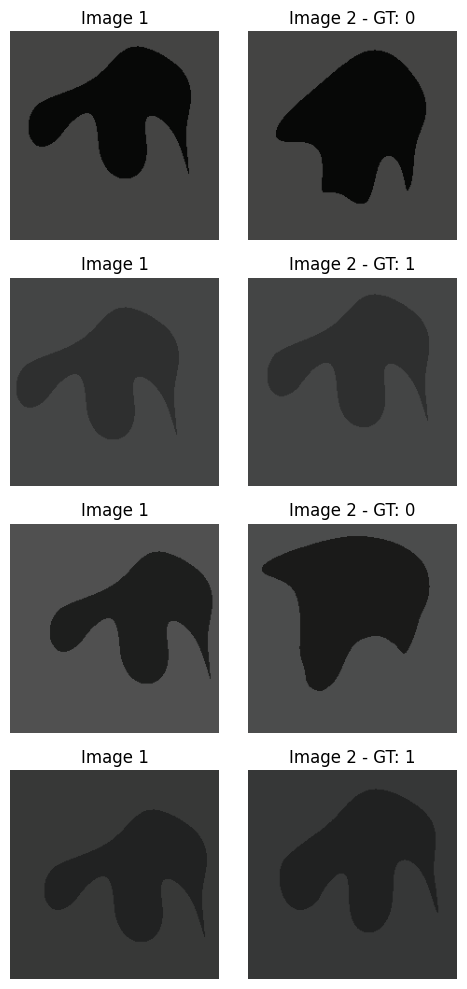

In [27]:
# Example usage to display 5 pairs of images
fig, axs = plt.subplots(4, 2, figsize=(5, 10))

for i in range(4):
    idx = np.random.randint(0, len(dataset_RSA) - 1)
    img1, img2, gt = dataset_RSA[idx]  # Get image pair and ground truth
    img1 = denormalize(img1)
    img2 = denormalize(img2)
    img1_pil = tensor_to_pil(img1)
    img2_pil = tensor_to_pil(img2)

    axs[i, 0].imshow(img1_pil)
    axs[i, 0].set_title('Image 1')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(img2_pil)
    axs[i, 1].set_title(f'Image 2 - GT: {gt}')
    axs[i, 1].axis('off')

plt.tight_layout()
#plt.savefig(dic_training + 'image_pairs_training_RSD.pdf')
plt.show()

**Neural network**

Get pre-trained weights

In [30]:
# COND1
#create dataset for RSA and RSD
#parameters: length, reference_shape, test_shape, data_dict, positions, transform=None)
len_dataset = (360*4)
dataset_RSA = ShapeImageDataset(len_dataset, reference_shapeA, data_Cond1, positions, preprocess)
dataset_RSD = ShapeImageDataset(len_dataset, reference_shapeD, data_Cond1, positions, preprocess)

In [31]:
# dataset loader
dataset_loader_RSA = DataLoader(dataset_RSA, 64)
dataset_loader_RSD = DataLoader(dataset_RSD, 64)

In [32]:
# experiment-dependent function to process an epoch of data
epoch_fun = osculari.paradigms.forced_choice.epoch_loop

In [33]:
lr = 0.01

In [53]:
#load pretrained weights
Animal_weights_layer0_NP = 'Animal_weights_layer0_NP.pt'
Animal_weights_layer1_NP = 'Animal_weights_layer1_NP.pt'
Animal_weights_layer2_NP = 'Animal_weights_layer2_NP.pt'

# load weights
def load_weights(model):
  PATH = dic_pretraining + model
  pretrained_weights = torch.load(PATH)
  return pretrained_weights

In [54]:
weights_layer0_NP = load_weights(Animal_weights_layer0_NP)
weights_layer1_NP = load_weights(Animal_weights_layer1_NP)
weights_layer2_NP = load_weights(Animal_weights_layer2_NP)

Training

In [36]:
#####################################################################
# RESNET WEIGHTS - NO PRE-TRAINING (and no pooling) layer0
#####################################################################

# network
architecture = 'resnet50'        # network's architecture
weights = 'resnet50'             # the pretrained weights
img_size = 224                   # network's input size
layer = 'block0'                    # the readout layer
pooling = None
readout_kwargs = {               # parameters for extracting features from the pretrained network
    'architecture': architecture,
    'weights': weights,
    'layers': layer,
    'img_size': img_size,
    'pooling': pooling
}

# model with pre-trained weights
original_model_RSA = osculari.models.paradigm_2afc_merge_concatenate(**readout_kwargs)
original_model_RSD = osculari.models.paradigm_2afc_merge_concatenate(**readout_kwargs)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 120MB/s]


In [37]:
# RS-A
params_to_optimize = [{'params': [p for p in original_model_RSA.fc.parameters()]}]
optimiser = torch.optim.SGD(params_to_optimize, lr=lr, momentum=0.9, weight_decay=1e-4)
# calling the generic train_linear_probe function
training_log = osculari.paradigms.paradigm_utils.train_linear_probe(
    original_model_RSA, dataset_loader_RSA, epoch_fun, 'my_data/osculari_test/', device="cuda",
    epochs = 10,
    optimiser=optimiser
    )

[000] accuracy=0.492 loss=40850.191
[001] accuracy=0.537 loss=43929.217
[002] accuracy=0.588 loss=36607.165
[003] accuracy=0.578 loss=40198.453
[004] accuracy=0.712 loss=15337.757
[005] accuracy=0.791 loss=6514.998
[006] accuracy=0.876 loss=3207.714
[007] accuracy=0.892 loss=2835.172
[008] accuracy=0.870 loss=3407.650
[009] accuracy=0.902 loss=2287.055


In [38]:
# save RSA model's weigths
PATH = dic_training + 'training_originalmodel-RSA.pt'
torch.save(original_model_RSA.state_dict(), PATH)

In [39]:
# RS-D
params_to_optimize = [{'params': [p for p in original_model_RSD.fc.parameters()]}]
optimiser = torch.optim.SGD(params_to_optimize, lr=lr, momentum=0.9, weight_decay=1e-4)
# calling the generic train_linear_probe function
training_log = osculari.paradigms.paradigm_utils.train_linear_probe(
    original_model_RSD, dataset_loader_RSD, epoch_fun, 'my_data/osculari_test/', device="cuda",
    epochs = 10,
    optimiser=optimiser
    )

[000] accuracy=0.583 loss=16162.622
[001] accuracy=0.747 loss=4737.952
[002] accuracy=0.846 loss=1989.213
[003] accuracy=0.863 loss=2117.640
[004] accuracy=0.782 loss=3730.558
[005] accuracy=0.895 loss=1537.579
[006] accuracy=0.908 loss=891.384
[007] accuracy=0.938 loss=627.565
[008] accuracy=0.944 loss=399.136
[009] accuracy=0.953 loss=390.649


In [41]:
# save RSD model's weigths
PATH = dic_training + 'training_originalmodel-RSD.pt'
torch.save(original_model_RSD.state_dict(), PATH)

In [42]:
##############################################
# No pooling, layer 0 - pretrained
##############################################

# network
architecture = 'resnet50'        # network's architecture
weights = 'resnet50'             # the pretrained weights
img_size = 224                   # network's input size
layer = 'block0'                    # the readout layer
pooling = None
readout_kwargs = {               # parameters for extracting features from the pretrained network
    'architecture': architecture,
    'weights': weights,
    'layers': layer,
    'img_size': img_size,
    'pooling': pooling
}

# model with pre-trained weights
layer0_NP_RSA = osculari.models.paradigm_2afc_merge_concatenate(**readout_kwargs)
layer0_NP_RSD = osculari.models.paradigm_2afc_merge_concatenate(**readout_kwargs)

# change weights
layer0_NP_RSA.load_state_dict(weights_layer0_NP)
layer0_NP_RSD.load_state_dict(weights_layer0_NP)

<All keys matched successfully>

In [43]:
# RS-A
params_to_optimize = [{'params': [p for p in layer0_NP_RSA.fc.parameters()]}]
optimiser = torch.optim.SGD(params_to_optimize, lr=lr, momentum=0.9, weight_decay=1e-4)
# calling the generic train_linear_probe function
training_log = osculari.paradigms.paradigm_utils.train_linear_probe(
    layer0_NP_RSA, dataset_loader_RSA, epoch_fun, 'my_data/osculari_test/', device="cuda",
    epochs = 10,
    optimiser=optimiser
    )

[000] accuracy=0.563 loss=20340.126
[001] accuracy=0.575 loss=37023.115
[002] accuracy=0.527 loss=53853.199
[003] accuracy=0.662 loss=26756.938
[004] accuracy=0.608 loss=36098.372
[005] accuracy=0.644 loss=26284.730
[006] accuracy=0.782 loss=8954.255
[007] accuracy=0.832 loss=4659.140
[008] accuracy=0.875 loss=3548.279
[009] accuracy=0.853 loss=3637.735


In [44]:
# save RSA model's weigths
PATH = dic_training + 'training_pret_layer0NP-RSA.pt'
torch.save(layer0_NP_RSA.state_dict(), PATH)

In [45]:
# RS-D
params_to_optimize = [{'params': [p for p in layer0_NP_RSD.fc.parameters()]}]
optimiser = torch.optim.SGD(params_to_optimize, lr=lr, momentum=0.9, weight_decay=1e-4)
# calling the generic train_linear_probe function
training_log = osculari.paradigms.paradigm_utils.train_linear_probe(
    layer0_NP_RSD, dataset_loader_RSD, epoch_fun, 'my_data/osculari_test/', device="cuda",
    epochs = 10,
    optimiser=optimiser
    )

[000] accuracy=0.496 loss=41249.587
[001] accuracy=0.596 loss=35343.136
[002] accuracy=0.658 loss=23969.406
[003] accuracy=0.656 loss=20804.846
[004] accuracy=0.787 loss=10986.300
[005] accuracy=0.844 loss=5026.798
[006] accuracy=0.927 loss=1456.571
[007] accuracy=0.927 loss=1354.412
[008] accuracy=0.934 loss=1196.681
[009] accuracy=0.938 loss=982.537


In [46]:
# save RSD model's weigths
PATH = dic_training + 'training_pret_layer0NP-RSD.pt'
torch.save(layer0_NP_RSD.state_dict(), PATH)

In [47]:
##############################################
# No pooling, layer 1 - pretrained
##############################################

# network
architecture = 'resnet50'        # network's architecture
weights = 'resnet50'             # the pretrained weights
img_size = 224                   # network's input size
layer = 'block1'                    # the readout layer
pooling = None
readout_kwargs = {               # parameters for extracting features from the pretrained network
    'architecture': architecture,
    'weights': weights,
    'layers': layer,
    'img_size': img_size,
    'pooling': pooling
}

# model with pre-trained weights
layer1_NP_RSA = osculari.models.paradigm_2afc_merge_concatenate(**readout_kwargs)
layer1_NP_RSD = osculari.models.paradigm_2afc_merge_concatenate(**readout_kwargs)

# change weights
layer1_NP_RSA.load_state_dict(weights_layer1_NP)
layer1_NP_RSD.load_state_dict(weights_layer1_NP)

<All keys matched successfully>

In [48]:
# RS-A
params_to_optimize = [{'params': [p for p in layer1_NP_RSA.fc.parameters()]}]
optimiser = torch.optim.SGD(params_to_optimize, lr=lr, momentum=0.9, weight_decay=1e-4)
# calling the generic train_linear_probe function
training_log = osculari.paradigms.paradigm_utils.train_linear_probe(
    layer1_NP_RSA, dataset_loader_RSA, epoch_fun, 'my_data/osculari_test/', device="cuda",
    epochs = 10,
    optimiser=optimiser
    )

[000] accuracy=0.528 loss=4976.623
[001] accuracy=0.562 loss=11180.030
[002] accuracy=0.544 loss=13004.003
[003] accuracy=0.656 loss=7371.487
[004] accuracy=0.738 loss=3274.972
[005] accuracy=0.740 loss=3071.794
[006] accuracy=0.871 loss=882.912
[007] accuracy=0.874 loss=770.660
[008] accuracy=0.885 loss=736.082
[009] accuracy=0.892 loss=699.342


In [49]:
# save RSA model's weigths
PATH = dic_training + 'training_pret_layer1NP-RSA.pt'
torch.save(layer1_NP_RSA.state_dict(), PATH)

In [50]:
# RS-D
params_to_optimize = [{'params': [p for p in layer1_NP_RSD.fc.parameters()]}]
optimiser = torch.optim.SGD(params_to_optimize, lr=lr, momentum=0.9, weight_decay=1e-4)
# calling the generic train_linear_probe function
training_log = osculari.paradigms.paradigm_utils.train_linear_probe(
    layer1_NP_RSD, dataset_loader_RSD, epoch_fun, 'my_data/osculari_test/', device="cuda",
    epochs = 10,
    optimiser=optimiser
    )

[000] accuracy=0.488 loss=23975.041
[001] accuracy=0.548 loss=23864.597
[002] accuracy=0.649 loss=7818.299
[003] accuracy=0.852 loss=1740.983
[004] accuracy=0.788 loss=3263.786
[005] accuracy=0.925 loss=556.750
[006] accuracy=0.940 loss=318.597
[007] accuracy=0.940 loss=485.571
[008] accuracy=0.924 loss=480.415
[009] accuracy=0.931 loss=415.803


In [51]:
# save RSD model's weigths
PATH = dic_training + 'training_pret_layer1NP-RSD.pt'
torch.save(layer1_NP_RSD.state_dict(), PATH)

In [55]:
##############################################
# No pooling, layer 2 - pretrained
##############################################

# network
architecture = 'resnet50'        # network's architecture
weights = 'resnet50'             # the pretrained weights
img_size = 224                   # network's input size
layer = 'block2'                    # the readout layer
pooling = None
readout_kwargs = {               # parameters for extracting features from the pretrained network
    'architecture': architecture,
    'weights': weights,
    'layers': layer,
    'img_size': img_size,
    'pooling': pooling
}

# model with pre-trained weights
layer2_NP_RSA = osculari.models.paradigm_2afc_merge_concatenate(**readout_kwargs)
layer2_NP_RSD = osculari.models.paradigm_2afc_merge_concatenate(**readout_kwargs)

# change weights
layer2_NP_RSA.load_state_dict(weights_layer2_NP)
layer2_NP_RSD.load_state_dict(weights_layer2_NP)

<All keys matched successfully>

In [56]:
# RS-A
params_to_optimize = [{'params': [p for p in layer2_NP_RSA.fc.parameters()]}]
optimiser = torch.optim.SGD(params_to_optimize, lr=lr, momentum=0.9, weight_decay=1e-4)
# calling the generic train_linear_probe function
training_log = osculari.paradigms.paradigm_utils.train_linear_probe(
    layer2_NP_RSA, dataset_loader_RSA, epoch_fun, 'my_data/osculari_test/', device="cuda",
    epochs = 10,
    optimiser=optimiser
    )

[000] accuracy=0.561 loss=1520.607
[001] accuracy=0.710 loss=1872.010
[002] accuracy=0.644 loss=2842.851
[003] accuracy=0.796 loss=1057.919
[004] accuracy=0.810 loss=829.653
[005] accuracy=0.919 loss=247.684
[006] accuracy=0.929 loss=172.582
[007] accuracy=0.933 loss=145.929
[008] accuracy=0.931 loss=158.527
[009] accuracy=0.928 loss=145.369


In [57]:
# save RSA model's weigths
PATH = dic_training + 'training_pret_layer2NP-RSA.pt'
torch.save(layer2_NP_RSA.state_dict(), PATH)

In [58]:
# RS-D
params_to_optimize = [{'params': [p for p in layer2_NP_RSD.fc.parameters()]}]
optimiser = torch.optim.SGD(params_to_optimize, lr=lr, momentum=0.9, weight_decay=1e-4)
# calling the generic train_linear_probe function
training_log = osculari.paradigms.paradigm_utils.train_linear_probe(
    layer2_NP_RSD, dataset_loader_RSD, epoch_fun, 'my_data/osculari_test/', device="cuda",
    epochs = 10,
    optimiser=optimiser
    )

[000] accuracy=0.509 loss=8350.893
[001] accuracy=0.694 loss=2871.454
[002] accuracy=0.837 loss=832.076
[003] accuracy=0.841 loss=858.316
[004] accuracy=0.944 loss=158.713
[005] accuracy=0.942 loss=176.864
[006] accuracy=0.958 loss=92.115
[007] accuracy=0.953 loss=117.179
[008] accuracy=0.956 loss=128.806
[009] accuracy=0.949 loss=128.121


In [59]:
# save RSD model's weigths
PATH = dic_training + 'training_pret_layer2NP-RSD.pt'
torch.save(layer2_NP_RSD.state_dict(), PATH)